In [39]:
import sys
import os
import IPython
import shutil
import random
import numpy as np
import mlflow
import mlflow.keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

from functions.normalize_images import normalize_images
from functions.display_images import display_images
from functions.load_images import load_images
from functions.create_dir import create_dir
from functions.format_filename import format_filename

In [40]:
# Set the seed for random operations.
random.seed(422)
tf.random.set_seed(422)

In [41]:
# Chemin vers le répertoire racine
root_path = "./data/"
raw_path = os.path.join(root_path, "raw")
proc_path = os.path.join(root_path, "proc")

# Créer les répertoires train et test
train_path = os.path.join(proc_path, "train")
val_path = os.path.join(proc_path, "val")
test_path = os.path.join(proc_path, "test")

create_dir(train_path)
create_dir(val_path)
create_dir(test_path)

# Liste des classes (yes, no)
classes = ["yes", "no"]

file_mapping = []

counter = 0

# Pour chaque classe
for class_name in classes:
    class_path = os.path.join(raw_path, class_name)
    images = os.listdir(class_path)

    # Mélanger aléatoirement les images
    random.shuffle(images)

    # Calculer la séparation des données (60/20/20)
    val_split_index = int(0.6 * len(images))
    test_split_index = int(0.8 * len(images))

    # Diviser les données en ensembles d'entraînement et de test
    train_images = images[:val_split_index]
    val_images = images[val_split_index:test_split_index]
    test_images = images[test_split_index:]

    # Créer les répertoires de classe dans les ensembles d'entraînement et de test
    train_class_path = os.path.join(train_path, class_name)
    val_class_path = os.path.join(val_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    create_dir(train_class_path)
    create_dir(val_class_path)
    create_dir(test_class_path)

    for dataset_name, dataset_images, dataset_class_path in [
        ("train", train_images, train_class_path),
        ("val", val_images, val_class_path),
        ("test", test_images, test_class_path),
    ]:
        for image in dataset_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(dataset_class_path, format_filename(counter))
            shutil.copy(src, dst)
            file_mapping += [
                {
                    "raw_img_path": src,
                    "proc_img_path": dst,
                    "class_name": class_name,
                    "dataset_name": dataset_name,
                }
            ]
            counter += 1

df = pd.DataFrame.from_records(file_mapping)
df.to_csv(os.path.join(root_path, "file_mapping.csv"), index=False, header=True)
df.groupby(["dataset_name", "class_name"]).count()

raw_img_path  proc_img_path
dataset_name class_name                             
test         no                    20             20
             yes                   31             31
train        no                    58             58
             yes                   93             93
val          no                    20             20
             yes                   31             31

In [42]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(val_path)
X_test, y_test = load_images(test_path)

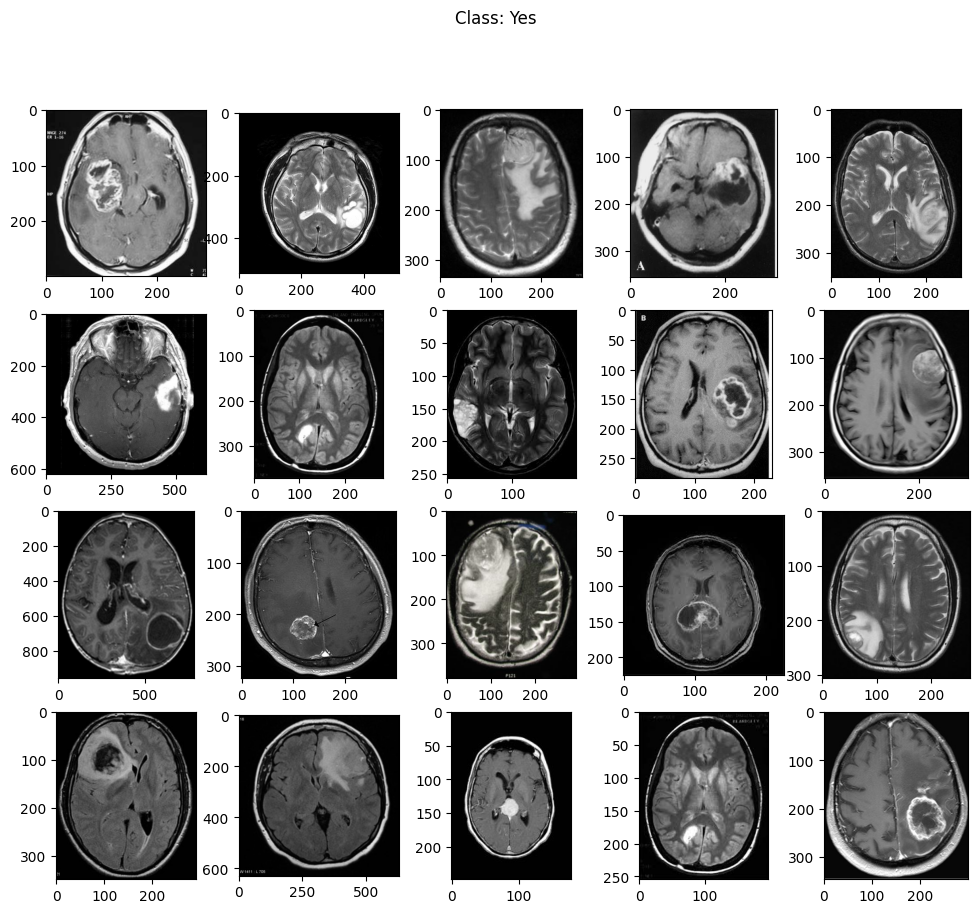

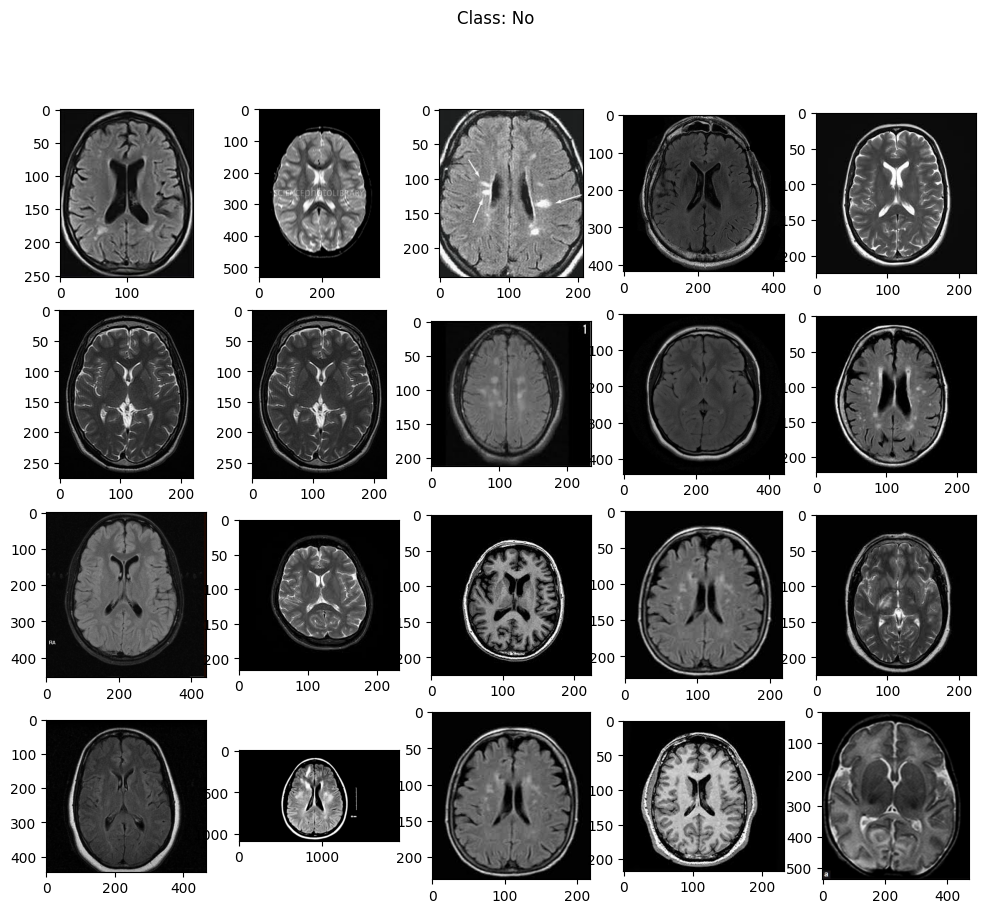

In [43]:
# Utilisation de la fonction avec X et y provenant du train
display_images(X_train, y_train, n=20)

In [44]:
# Utilisation de la fonction avec X (images non normalisées) et la taille cible
target_size = (224, 224)
X_train_norm = normalize_images(X_train, target_size)
X_val_norm = normalize_images(X_val, target_size)
X_test_norm = normalize_images(X_test, target_size)

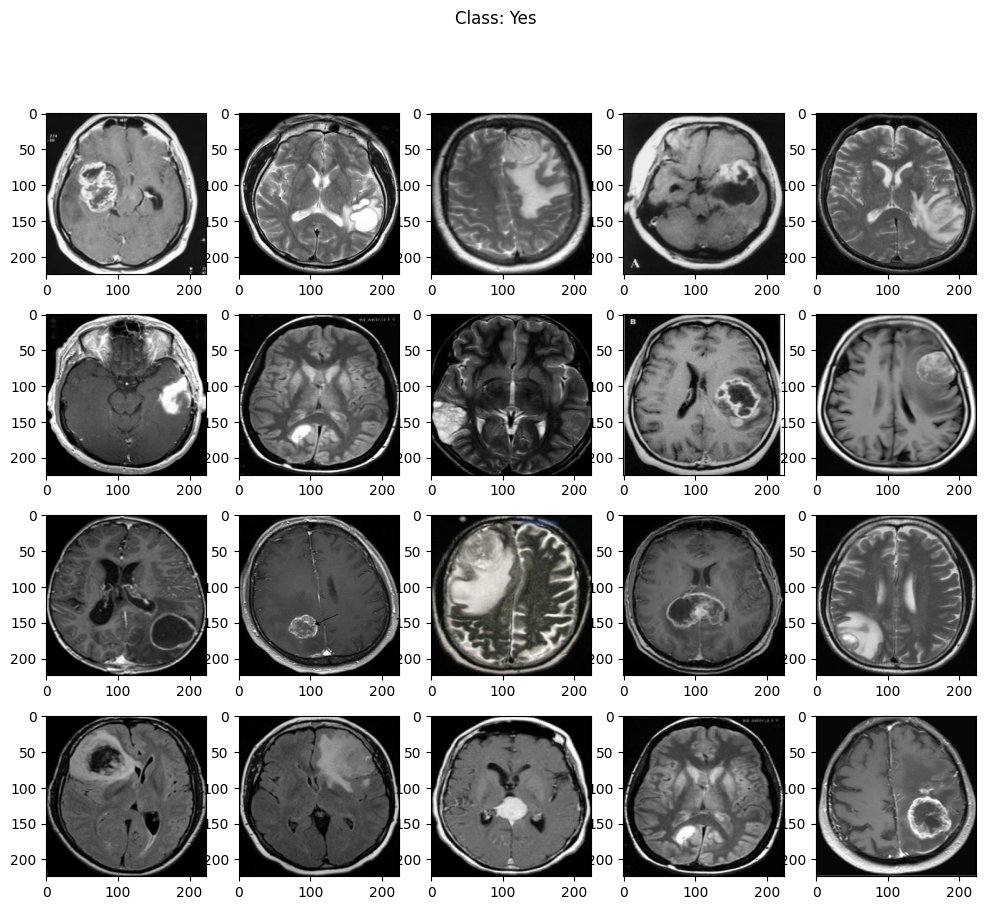

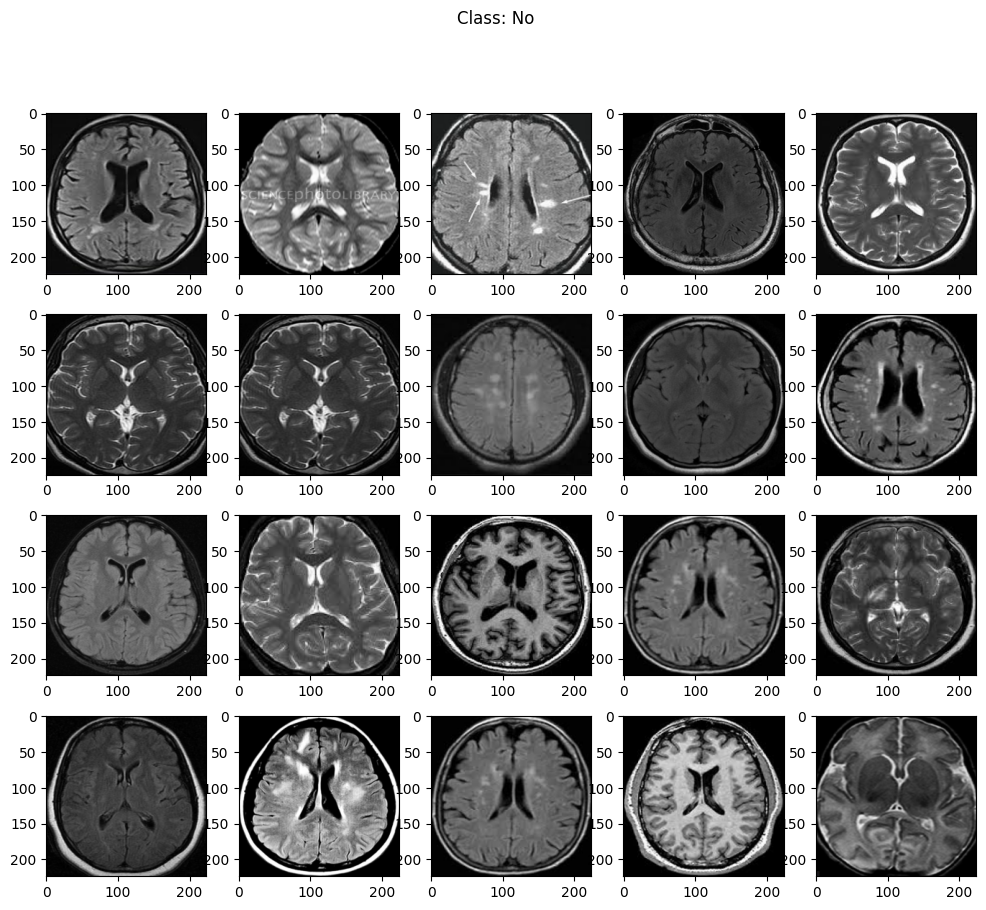

In [45]:
display_images(X_train_norm, y_train, 20)

In [46]:
# Créer un modèle VGG-16 pré-entraîné (ne pas inclure la couche dense finale)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation="sigmoid"))

# figer les poids du VGG
model.layers[0].trainable = False

# Compiler le modèle
model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=["accuracy"],
)

# Afficher la structure du modèle
model.summary()

# Créer un générateur d'images pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.05,
    shear_range=0.01,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
)

# Ajuster le générateur aux données d'entraînement
datagen.fit(X_train_norm)

# Créer un callback d'arrêt anticipé
early_stopping = EarlyStopping(
    monitor="val_loss",  # Surveiller la perte sur l'ensemble de validation
    patience=10,  # Arrêter l'entraînement si la perte ne diminue pas pendant 3 époques consécutives
    # Restaurer les poids du modèle aux meilleurs atteints pendant l'entraînement
    restore_best_weights=True,
    verbose=1,  # Afficher des messages lors de l'arrêt anticipé
)

BATCH_SIZE = 16

# Entraîner le modèle avec l'augmentation de données
history = model.fit(
    datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE),
    epochs=50,
    steps_per_epoch=len(X_train_norm) // BATCH_SIZE,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping],
)

model.evaluate(X_test_norm, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
X_train_norm.shape

In [ ]:
# plot model performance
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.yscale("log")
plt.plot(epochs_range, acc, label="Train Set")
plt.plot(epochs_range, val_acc, label="Val Set")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.yscale("log")
plt.plot(
    epochs_range,
    loss,
    label="Train Set",
)
plt.plot(epochs_range, val_loss, label="Val Set")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test_norm)

In [ ]:
y_pred = (y_pred_prob > 0.5).flatten()

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
not_ok_y_test = y_test[y_pred != y_test]
not_ok_X_test = X_test[y_pred != y_test]

display_images(not_ok_X_test, not_ok_y_test, 20)

In [ ]:
print("recall = ", recall_score(y_test, y_pred))
print("precision = ", precision_score(y_test, y_pred))
print("f1 score = ", f1_score(y_test, y_pred))
print("rocauc = ", roc_auc_score(y_test, y_pred_prob))

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2, label="Random")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [ ]:
plt.hist(y_pred_prob)

In [ ]:
# Save the model as keras
model.save("brain_tumor_detector.keras")

In [ ]:
# Config MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("NeuroApp")

# Start an MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("epochs", len(history.epoch))
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("num_classes", NUM_CLASSES)

    # Log metrics
    mlflow.log_metric("val_loss", val_loss[-1])
    mlflow.log_metric("val_accuracy", val_acc[-1])
    mlflow.log_metric("test_loss", model.evaluate(X_test_norm, y_test, verbose=0)[0])
    mlflow.log_metric(
        "test_accuracy", model.evaluate(X_test_norm, y_test, verbose=0)[1]
    )
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_pred_prob))

    # Log the model
    mlflow.keras.log_model(model, "models")

In [ ]:
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(MLFLOW_RUN)

predicted_test = loaded_model.predict(X_test_norm)

In [ ]:
# normalize predicted_test
predicted_test = (predicted_test > 0.5).astype(int)

# Calculate accuracy
correct = 0
for i in range(len(predicted_test)):
    if predicted_test[i] == int(y_test[i]):
        correct += 1

accuracy = correct / len(predicted_test)

print(f"Prediction accuracy: {accuracy:.2%}")

# Plot X_test_norm
num_images = len(X_test_norm)
rows = int(
    np.ceil(num_images / 5.0)
)  # Use np.ceil to round up to the nearest whole number
fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))
axes = axes.ravel()  # Flatten the axes array

# Hide axes for unused subplots
for ax in axes[num_images:]:
    ax.axis("off")

for i, image in enumerate(X_test_norm):
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")
    if predicted_test[i] == int(y_test[i]):
        axes[i].set_title(
            f"Predicted: {predicted_test[i][0]}, Actual: {y_test[i]}", color="green"
        )
    else:
        axes[i].set_title(
            f"Predicted: {predicted_test[i][0]}, Actual: {y_test[i]}", color="red"
        )

plt.tight_layout()
plt.show()